## ============================================================================
## CONFIDENCE-BASED PSEUDO-LABELING FOR BCCC DARKNET DATASET
## Ensemble Approach: Isolation Forest + Autoencoder
## ============================================================================


## ============================================================================
## CONFIGURATION
## ============================================================================


In [1]:
# ==========================
# Imports
# ==========================
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import joblib
import warnings
warnings.filterwarnings("ignore")

# ==========================
# Configuration
# ==========================

# TODO: CHANGE THIS TO YOUR ACTUAL CSV PATH
DATA_PATH = r"./data/bccc_darknet.csv"

OUTPUT_DIR = "./artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

RANDOM_STATE = 42
CONTAMINATION = 0.05          # expected anomaly ratio for IF (5%) [tunable]
AUTOENCODER_EPOCHS = 50
AUTOENCODER_BATCH_SIZE = 256
TOP_N_FEATURES = 50           # top-k variance features for stability

print("Configuration:")
print(f"  DATA_PATH     = {DATA_PATH}")
print(f"  OUTPUT_DIR    = {OUTPUT_DIR}")
print(f"  CONTAMINATION = {CONTAMINATION}")


2026-02-09 14:17:09.453331: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-09 14:17:09.453565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 14:17:09.487676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-09 14:17:11.977586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Configuration:
  DATA_PATH     = ./data/bccc_darknet.csv
  OUTPUT_DIR    = ./artifacts
  CONTAMINATION = 0.05


## ============================================================================
## Data loading & preprocessing
### Cell 2 – Load data and basic cleaning (code)
## ============================================================================



In [2]:
print("=" * 70)
print("STEP 1: LOAD & CLEAN DATA")
print("=" * 70)

# Load CSV
data = pd.read_csv(DATA_PATH)
print(f"✓ Dataset loaded: {data.shape}")
print(f"  Columns (first 10): {data.columns[:10].tolist()}")

# Select numeric features only (drop non-numeric for this pipeline)
features = data.select_dtypes(include=["float64", "int64"]).copy()
print(f"\n✓ Numeric features selected: {features.shape[1]} features")

# Replace inf/-inf with NaN
features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN with median of each column
features.fillna(features.median(), inplace=True)

# Clip extreme values to avoid numerical issues
features = features.clip(-1e9, 1e9)

print("✓ Cleaning done:")
print(f"  Final numeric feature matrix: {features.shape}")


STEP 1: LOAD & CLEAN DATA
✓ Dataset loaded: (25538, 475)
  Columns (first 10): ['flow_id', 'timestamp', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol', 'duration', 'packets_count', 'fwd_packets_count']

✓ Numeric features selected: 467 features
✓ Cleaning done:
  Final numeric feature matrix: (25538, 467)


## ============================================================================
## Cell 3 – Feature selection (variance-based) and scaling (code)
## ============================================================================

In [3]:
print("\n" + "=" * 70)
print("STEP 2: FEATURE SELECTION & SCALING")
print("=" * 70)

# --- Feature selection: top-N by variance (unsupervised) ---
feature_variance = features.var().sort_values(ascending=False)

if len(features.columns) > TOP_N_FEATURES:
    selected_features = feature_variance.nlargest(TOP_N_FEATURES).index
    features_sel = features[selected_features].copy()
    print(f"✓ Selected top {TOP_N_FEATURES} features by variance")
else:
    features_sel = features.copy()
    print(f"✓ Using all {len(features.columns)} features (less than TOP_N_FEATURES)")

print(f"  Selected feature matrix: {features_sel.shape}")

# Save selected feature names for downstream reference
feature_names = features_sel.columns.tolist()

# --- Standardization ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_sel)

print("\n✓ Data scaled with StandardScaler")
print(f"  Shape: {X_scaled.shape}")
print(f"  Mean (overall): {X_scaled.mean():.6f}")
print(f"  Std  (overall): {X_scaled.std():.6f}")

# Persist scaler
scaler_path = os.path.join(OUTPUT_DIR, "scaler_pseudo_labeling.pkl")
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")



STEP 2: FEATURE SELECTION & SCALING
✓ Selected top 50 features by variance
  Selected feature matrix: (25538, 50)

✓ Data scaled with StandardScaler
  Shape: (25538, 50)
  Mean (overall): 0.000000
  Std  (overall): 1.000000
✓ Scaler saved to: ./artifacts/scaler_pseudo_labeling.pkl


In [4]:
# After STEP 2 feature selection
print("\nTop selected features:")
for i, fname in enumerate(feature_names[:25], 1):
    print(f"{i}. {fname}")


Top selected features:
1. packet_IAT_min
2. packets_IAT_mode
3. packets_IAT_median
4. packets_IAT_mean
5. packet_IAT_max
6. packet_IAT_total
7. fwd_packets_IAT_min
8. fwd_packets_IAT_mode
9. fwd_packets_IAT_median
10. fwd_packets_IAT_mean
11. fwd_packets_IAT_max
12. fwd_packets_IAT_total
13. bwd_packets_IAT_min
14. bwd_packets_IAT_mode
15. bwd_packets_IAT_median
16. bwd_packets_IAT_mean
17. bwd_packets_IAT_max
18. bwd_packets_IAT_total
19. avg_bwd_bulk_rate
20. bytes_rate
21. avg_fwd_bulk_rate
22. variance_fwd_packets_delta_len
23. variance_fwd_payload_bytes_delta_len
24. variance_payload_bytes_delta_len
25. variance_packets_delta_len


## ============================================================================
## Isolation Forest model
#### Cell 4 – Train Isolation Forest & get anomaly scores (code)
## ============================================================================

In [5]:
print("\n" + "=" * 70)
print("STEP 3: ISOLATION FOREST ANOMALY DETECTION")
print("=" * 70)

iso_model = IsolationForest(
    n_estimators=200,
    contamination=CONTAMINATION,  # approximate expected outlier proportion
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("✓ Training Isolation Forest...")
iso_model.fit(X_scaled)

# Predictions: -1 = anomaly, 1 = normal
iso_preds = iso_model.predict(X_scaled)
iso_scores = iso_model.score_samples(X_scaled)  # lower = more anomalous

iso_anomalies = np.where(iso_preds == -1)[0]

print("\n✓ Isolation Forest results:")
print(f"  Total samples:         {len(X_scaled)}")
print(f"  Anomalies detected:    {len(iso_anomalies)}"
      f" ({len(iso_anomalies)/len(X_scaled)*100:.2f}%)")
print(f"  Score range:           [{iso_scores.min():.4f}, {iso_scores.max():.4f}]")

# Save model
iso_path = os.path.join(OUTPUT_DIR, "isolation_forest_model.pkl")
joblib.dump(iso_model, iso_path)
print(f"✓ Isolation Forest model saved to: {iso_path}")



STEP 3: ISOLATION FOREST ANOMALY DETECTION
✓ Training Isolation Forest...

✓ Isolation Forest results:
  Total samples:         25538
  Anomalies detected:    1243 (4.87%)
  Score range:           [-0.7684, -0.3399]
✓ Isolation Forest model saved to: ./artifacts/isolation_forest_model.pkl


## ============================================================================
## Autoencoder model
## ============================================================================

In [6]:
print("\n" + "=" * 70)
print("STEP 4: AUTOENCODER TRAINING")
print("=" * 70)

input_dim = X_scaled.shape[1]
encoding_dim = 16  # bottleneck size (tunable)

print(f"Input dimension:   {input_dim}")
print(f"Encoding dimension:{encoding_dim}")

# Define Autoencoder architecture
input_layer = Input(shape=(input_dim,))
x = Dense(32, activation="relu")(input_layer)
encoded = Dense(encoding_dim, activation="relu")(x)

x = Dense(32, activation="relu")(encoded)
output_layer = Dense(input_dim, activation="linear")(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")

print("\n✓ Training Autoencoder (unsupervised)...")
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=AUTOENCODER_EPOCHS,
    batch_size=AUTOENCODER_BATCH_SIZE,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

print("\n✓ Autoencoder training complete")
print(f"  Final train loss: {history.history['loss'][-1]:.6f}")
print(f"  Final val   loss: {history.history['val_loss'][-1]:.6f}")



STEP 4: AUTOENCODER TRAINING
Input dimension:   50
Encoding dimension:16

✓ Training Autoencoder (unsupervised)...
Epoch 1/50


2026-02-09 14:17:20.970538: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9365 - val_loss: 0.3382
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5715 - val_loss: 0.2283
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3953 - val_loss: 0.1898
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2937 - val_loss: 0.1629
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2450 - val_loss: 0.1522
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2149 - val_loss: 0.1407
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1951 - val_loss: 0.1324
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1723 - val_loss: 0.1299
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1491 - val_loss: 0.1223
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1260 - val_loss: 0.1151
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1090 - val_loss: 0.1080
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0954 - val_loss: 0.1051


## ============================================================================
## Compute reconstruction errors and AE anomalies (code)
## ============================================================================

In [7]:
print("\n" + "=" * 70)
print("STEP 5: AUTOENCODER ANOMALY SCORING")
print("=" * 70)

# Reconstruction for all samples
reconstructions = autoencoder.predict(X_scaled, verbose=0)
mse = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Threshold: 95th percentile of reconstruction error (common practice) [tunable]
threshold = np.percentile(mse, 95)
ae_anomalies = np.where(mse > threshold)[0]

print("✓ Autoencoder anomaly results:")
print(f"  Threshold (95th percentile): {threshold:.6f}")
print(f"  Anomalies detected:          {len(ae_anomalies)}"
      f" ({len(ae_anomalies)/len(X_scaled)*100:.2f}%)")
print(f"  MSE range:                   [{mse.min():.6f}, {mse.max():.6f}]")

# Save AE model and errors
ae_model_path = os.path.join(OUTPUT_DIR, "autoencoder_model.h5")
err_path = os.path.join(OUTPUT_DIR, "reconstruction_errors.npy")

autoencoder.save(ae_model_path)
np.save(err_path, mse)

print(f"✓ Autoencoder model saved to: {ae_model_path}")
print(f"✓ Reconstruction errors saved to: {err_path}")



STEP 5: AUTOENCODER ANOMALY SCORING


✓ Autoencoder anomaly results:
  Threshold (95th percentile): 0.026477
  Anomalies detected:          1277 (5.00%)
  MSE range:                   [0.000373, 102.210882]
✓ Autoencoder model saved to: ./artifacts/autoencoder_model.h5
✓ Reconstruction errors saved to: ./artifacts/reconstruction_errors.npy


## ============================================================================
## Ensemble pseudo-labeling & confidence scoring
### Cell 7 – Ensemble logic: IF + AE → pseudo-labels + confidence (code)
## ============================================================================

In [8]:
print("\n" + "=" * 70)
print("STEP 6: ENSEMBLE PSEUDO-LABELING (IF + AE)")
print("=" * 70)

# ---- 1) Identify overlap and disagreements ----
high_confidence_anomalies = np.intersect1d(iso_anomalies, ae_anomalies)
if_only = np.setdiff1d(iso_anomalies, ae_anomalies)
ae_only = np.setdiff1d(ae_anomalies, iso_anomalies)
union_anomalies = np.union1d(iso_anomalies, ae_anomalies)

print("✓ Anomaly breakdown:")
print(f"  High confidence (IF ∩ AE): {len(high_confidence_anomalies)}")
print(f"  IF only:                    {len(if_only)}")
print(f"  AE only:                    {len(ae_only)}")
print(f"  Total unique anomalies:     {len(union_anomalies)}")
print(f"  Normal (neither):           {len(X_scaled) - len(union_anomalies)}")

# ---- 2) Initialize labels and confidence ----
# pseudo_label: 0 = normal, 1 = anomaly
pseudo_labels = np.zeros(len(X_scaled), dtype=int)
confidence_scores = np.zeros(len(X_scaled), dtype=float)

# Strategy (conservative):
#   - Label as anomaly ONLY when both models agree
#   - Give lower confidence scores to model-specific anomalies for analysis

# HIGH CONFIDENCE: IF and AE both say anomaly
pseudo_labels[high_confidence_anomalies] = 1
confidence_scores[high_confidence_anomalies] = 1.0

# MEDIUM CONFIDENCE: only one model flags as anomaly
# (we keep label = 0 but record that they are suspicious via confidence)
confidence_scores[if_only] = 0.3
confidence_scores[ae_only] = 0.3

print("\n✓ Pseudo-labels and confidence scores created:")
print(f"  Anomalies (label=1): {np.sum(pseudo_labels == 1)}")
print(f"  Normals  (label=0):  {np.sum(pseudo_labels == 0)}")
print(f"  Confidence - min:    {confidence_scores.min():.4f}")
print(f"                max:    {confidence_scores.max():.4f}")
print(f"                mean:   {confidence_scores.mean():.4f}")



STEP 6: ENSEMBLE PSEUDO-LABELING (IF + AE)
✓ Anomaly breakdown:
  High confidence (IF ∩ AE): 369
  IF only:                    874
  AE only:                    908
  Total unique anomalies:     2151
  Normal (neither):           23387

✓ Pseudo-labels and confidence scores created:
  Anomalies (label=1): 369
  Normals  (label=0):  25169
  Confidence - min:    0.0000
                max:    1.0000
                mean:   0.0354


## Build labeled DataFrame & save (code)

In [9]:
print("\n" + "=" * 70)
print("STEP 7: BUILD & SAVE LABELED DATASET")
print("=" * 70)

# DataFrame with selected (scaled) features
df_labeled = pd.DataFrame(X_scaled, columns=feature_names)

# Add labels and meta-columns
df_labeled["pseudo_label"] = pseudo_labels
df_labeled["confidence_score"] = confidence_scores
df_labeled["if_anomaly"] = 0
df_labeled["ae_anomaly"] = 0

df_labeled.loc[iso_anomalies, "if_anomaly"] = 1
df_labeled.loc[ae_anomalies, "ae_anomaly"] = 1

print("✓ Labeled DataFrame summary:")
print(f"  Shape:   {df_labeled.shape}")
print(f"  Columns: {df_labeled.columns.tolist()}")

# Save full labeled dataset
labeled_all_path = os.path.join(OUTPUT_DIR, "bccc_labeled_all_confidence.csv")
df_labeled.to_csv(labeled_all_path, index=False)
print(f"\n✓ Saved full labeled dataset to: {labeled_all_path}")

# Optionally, create a "high-confidence" subset:
# all high-confidence anomalies + all normals
high_conf_mask = (pseudo_labels == 1)
df_high_conf = pd.concat(
    [df_labeled[high_conf_mask], df_labeled[pseudo_labels == 0]],
    axis=0
).reset_index(drop=True)

labeled_high_conf_path = os.path.join(OUTPUT_DIR, "bccc_labeled_high_confidence.csv")
df_high_conf.to_csv(labeled_high_conf_path, index=False)
print(f"✓ Saved high-confidence dataset to: {labeled_high_conf_path}")



STEP 7: BUILD & SAVE LABELED DATASET
✓ Labeled DataFrame summary:
  Shape:   (25538, 54)
  Columns: ['packet_IAT_min', 'packets_IAT_mode', 'packets_IAT_median', 'packets_IAT_mean', 'packet_IAT_max', 'packet_IAT_total', 'fwd_packets_IAT_min', 'fwd_packets_IAT_mode', 'fwd_packets_IAT_median', 'fwd_packets_IAT_mean', 'fwd_packets_IAT_max', 'fwd_packets_IAT_total', 'bwd_packets_IAT_min', 'bwd_packets_IAT_mode', 'bwd_packets_IAT_median', 'bwd_packets_IAT_mean', 'bwd_packets_IAT_max', 'bwd_packets_IAT_total', 'avg_bwd_bulk_rate', 'bytes_rate', 'avg_fwd_bulk_rate', 'variance_fwd_packets_delta_len', 'variance_fwd_payload_bytes_delta_len', 'variance_payload_bytes_delta_len', 'variance_packets_delta_len', 'fwd_bytes_rate', 'bwd_bytes_rate', 'fwd_payload_bytes_variance', 'fwd_segment_size_variance', 'total_payload_bytes', 'payload_bytes_variance', 'segment_size_variance', 'bwd_total_payload_bytes', 'bwd_bulk_total_size', 'fwd_total_payload_bytes', 'fwd_bulk_total_size', 'variance_bwd_payload_byt

## Text summary (code)

In [10]:
num_total = len(X_scaled)
num_anom = int(np.sum(pseudo_labels == 1))
num_norm = int(np.sum(pseudo_labels == 0))

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"Total samples:               {num_total}")
print(f"Anomalies (pseudo_label=1):  {num_anom} ({num_anom/num_total*100:.2f}%)")
print(f"Normals   (pseudo_label=0):  {num_norm} ({num_norm/num_total*100:.2f}%)")
print(f"High-confidence anomalies:   {len(high_confidence_anomalies)}")
print(f"IF-only anomalies:           {len(if_only)}")
print(f"AE-only anomalies:           {len(ae_only)}")
print(f"Confidence mean:             {confidence_scores.mean():.4f}")

print("\nNext step: Use "
      "'bccc_labeled_high_confidence.csv' to train a supervised model (e.g., Random Forest).")



SUMMARY
Total samples:               25538
Anomalies (pseudo_label=1):  369 (1.44%)
Normals   (pseudo_label=0):  25169 (98.56%)
High-confidence anomalies:   369
IF-only anomalies:           874
AE-only anomalies:           908
Confidence mean:             0.0354

Next step: Use 'bccc_labeled_high_confidence.csv' to train a supervised model (e.g., Random Forest).


### Visualization

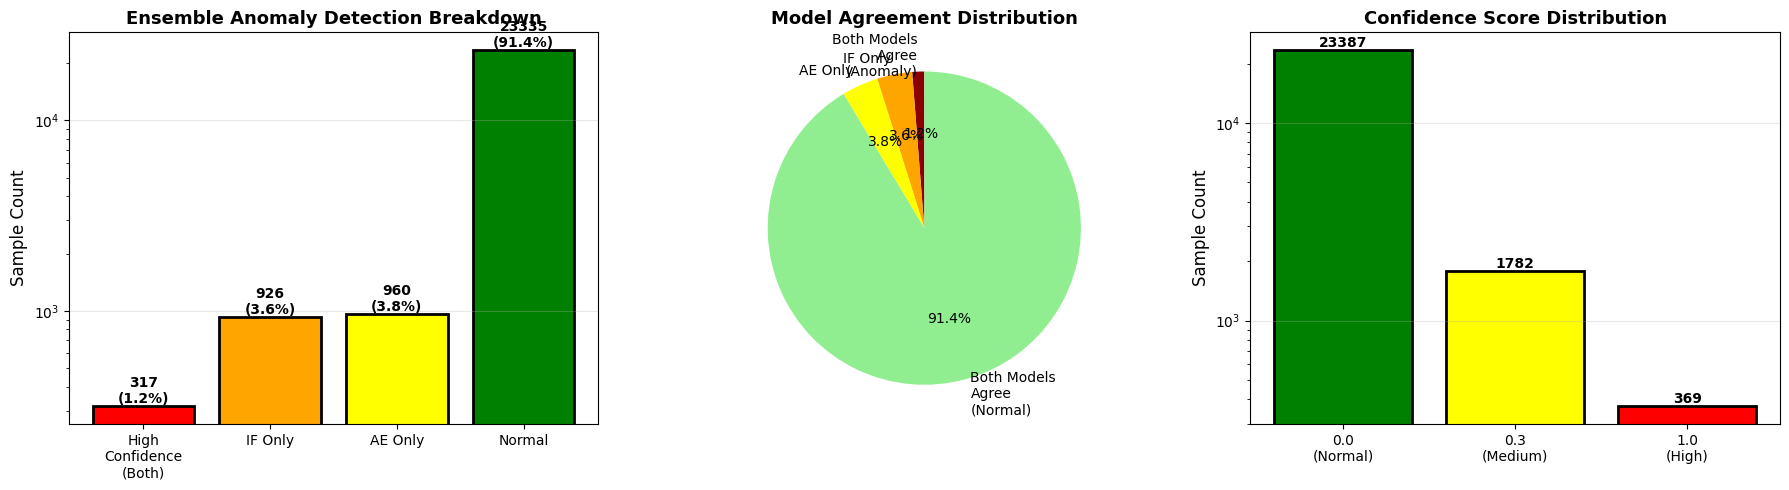

✓ Summary visualization saved!


In [11]:
# Add this cell to your notebook:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Anomaly breakdown
categories = ['High\nConfidence\n(Both)', 'IF Only', 'AE Only', 'Normal']
values = [317, 926, 960, 23335]
colors = ['red', 'orange', 'yellow', 'green']

axes[0].bar(categories, values, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Sample Count', fontsize=12)
axes[0].set_title('Ensemble Anomaly Detection Breakdown', fontsize=13, fontweight='bold')
axes[0].set_yscale('log')  # Log scale for visibility
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(values):
    axes[0].text(i, v, f'{v}\n({v/25538*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# Plot 2: Model agreement
agreement_data = {
    'Both Models\nAgree\n(Anomaly)': 317,
    'IF Only': 926,
    'AE Only': 960,
    'Both Models\nAgree\n(Normal)': 23335
}

axes[1].pie(agreement_data.values(), labels=agreement_data.keys(), 
           autopct='%1.1f%%', startangle=90, colors=['darkred', 'orange', 'yellow', 'lightgreen'])
axes[1].set_title('Model Agreement Distribution', fontsize=13, fontweight='bold')

# Plot 3: Confidence distribution
confidence_dist = np.histogram(confidence_scores, bins=[0, 0.1, 0.3, 0.5, 1.0])
bins_labels = ['0.0\n(Normal)', '0.3\n(Medium)', '1.0\n(High)']
bin_values = [
    np.sum(confidence_scores == 0.0),
    np.sum(confidence_scores == 0.3),
    np.sum(confidence_scores == 1.0)
]

axes[2].bar(bins_labels, bin_values, color=['green', 'yellow', 'red'], 
           edgecolor='black', linewidth=2)
axes[2].set_ylabel('Sample Count', fontsize=12)
axes[2].set_title('Confidence Score Distribution', fontsize=13, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(bin_values):
    axes[2].text(i, v, f'{v}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('./artifacts/ensemble_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Summary visualization saved!")
